<a href="https://colab.research.google.com/github/partho1999/sentiment_analysis-with-reviews-feedback-data/blob/main/Airline_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Datasets/Reviews.csv")

In [ ]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
df['scores'] = df['Text'].apply(lambda Text: sid.polarity_scores(Text))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,scores
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'comp..."
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp..."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"{'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'co..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'comp..."


In [ ]:
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,scores,compound
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'comp...",0.9441
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp...",-0.5664
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"{'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'co...",0.8265
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'comp...",0.9468


In [ ]:
df['airline_sentiment'] = df['compound'].apply(lambda c: 'positive' if c>=0 else 'negative')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,scores,compound,airline_sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'comp...",0.9441,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp...",-0.5664,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"{'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'co...",0.8265,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'comp...",0.9468,positive


In [ ]:
review_df = df[['Text','airline_sentiment']]
print(review_df.shape)
review_df.head(5)

(568454, 2)


,Text,airline_sentiment
0,I have bought several of the Vitality canned d...,positive
1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,This is a confection that has been around a fe...,positive
3,If you are looking for the secret ingredient i...,positive
4,Great taffy at a great price. There was a wid...,positive


In [ ]:
review_df["airline_sentiment"].value_counts()

positive    507280
negative     61174
Name: airline_sentiment, dtype: int64

In [ ]:
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 0, ..., 0, 0, 0]),
 Index(['positive', 'negative'], dtype='object'))

In [ ]:
tweet = review_df.Text.values

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
# encoded_docs = tokenizer.texts_to_sequences(tweet)
# padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           4257280   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 4,273,931
Trainable params: 4,273,931
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
14212/14212 [==============================] - 2779s 195ms/step - loss: 0.2053 - accuracy: 0.9199 - val_loss: 0.1474 - val_accuracy: 0.9421
Epoch 2/5
14212/14212 [==============================] - 2733s 192ms/step - loss: 0.1450 - accuracy: 0.9432 - val_loss: 0.1305 - val_accuracy: 0.9486
Epoch 3/5
14212/14212 [==============================] - 2739s 193ms/step - loss: 0.1315 - accuracy: 0.9484 - val_loss: 0.1184 - val_accuracy: 0.9545
Epoch 4/5
14212/14212 [==============================] - 2752s 194ms/step - loss: 0.1254 - accuracy: 0.9513 - val_loss: 0.1223 - val_accuracy: 0.9534
Epoch 5/5
14212/14212 [==============================] - 2834s 199ms/step - loss: 0.1209 - accuracy: 0.9533 - val_loss: 0.1162 - val_accuracy: 0.9563


In [ ]:
model.save('/content/drive/MyDrive/Datasets/airline_sentiment_model.h5')

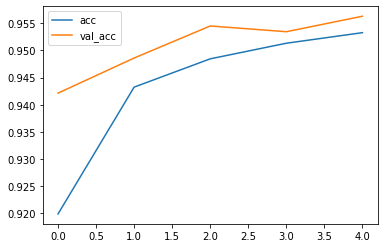

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

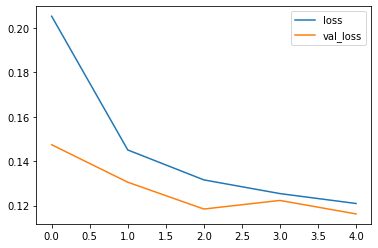

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [ ]:
# test_sentence1 = "I  enjoyed my journey on this flight."         
# predict_sentiment(test_sentence1)
# test_sentence2 = "This is the worst flight experience of my life!"
# predict_sentiment(test_sentence2)

In [ ]:
test_sentence1 = input('Enter your feedback:')
predict_sentiment(test_sentence1)

Enter your feedback:it was a bad flight
Predicted label:  negative


source:https://techvidvan.com/tutorials/python-sentiment-analysis/